# Classification

In [1]:
from pyspark.sql import SparkSession
from datetime import datetime, date
import pandas as pd
from pyspark.sql import Row
import pyspark.pandas as ps
from sklearn.model_selection import train_test_split
import numpy as np
import pyspark.sql.functions as F
from pyspark.ml.feature import StandardScaler
import plotly

In [2]:
spark = SparkSession.builder.appName('minadzb').getOrCreate()

In [3]:
df = spark.read.option("header",True).csv("weatherAUS.csv").drop('Date')
psdf = ps.DataFrame(df)

In [4]:
psdf.describe()

C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
C:\spark-3.3.1-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460,145460
unique,49,390,506,682,359,146,17,68,17,17,44,45,102,102,547,550,11,11,442,503,3,3
top,Canberra,NA,NA,0,NA,NA,NA,NA,N,SE,9,13,99,NA,NA,NA,NA,NA,NA,NA,No,No
freq,3436,1485,1261,91080,62790,69835,10326,10263,11758,10838,13649,12580,3391,4507,15065,15028,55888,59358,1767,3609,110319,110316


## Data preprocessing

### Filling missing data with mode (most common value)

In [5]:
psdf_nulls = psdf.replace('NA', None)
print(psdf_nulls.isnull().sum())

data_mode = psdf_nulls.copy()

for i in range(len(psdf_nulls.columns)):
    data_mode.iloc[:, i].fillna(psdf_nulls.iloc[:, i].mode()[0], inplace=True)

print(data_mode.isnull().sum())

C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
C:\spark-3.3.1-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
C:\spark-3.3.1-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


### Strings to floats

In [6]:
for col in data_mode:
    if(col == 'Location' or col == 'WindGustDir' or col == 'WindDir9am' or col == 'WindDir3pm' or col == 'RainToday' or col == 'RainTomorrow' ):
        continue
    data_mode[col] = data_mode[col].astype(float)

### Standarization

In [7]:
data_mode_std = data_mode.copy()
for col in data_mode:
    if(col == 'Location' or col == 'WindGustDir' or col == 'WindDir9am' or col == 'WindDir3pm' or col == 'RainToday' or col == 'RainTomorrow' ):
        continue
    data_mode_std[col] = (data_mode_std[col] - data_mode_std[col].mean()) / data_mode_std[col].std()


In [8]:
data_mode_std.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05,1.454600e+05
mean,-1.232376e-14,-2.423485e-14,1.144621e-14,-4.848846e-15,-6.630820e-14,-1.671461e-14,1.403871e-14,-3.563089e-14,2.138369e-15,5.095821e-15,1.123481e-11,2.722726e-12,-7.528060e-15,3.366681e-14,9.447590e-15,-2.265296e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.248348e+00,-3.945841e+00,-2.750957e-01,-1.490226e+00,-8.453858e-01,-2.555099e+00,-1.574875e+00,-2.118186e+00,-3.600998e+00,-2.518320e+00,-5.493275e+00,-5.726369e+00,-2.101095e+00,-2.279259e+00,-3.750956e+00,-3.944768e+00
25%,-7.039309e-01,-7.320441e-01,-2.750957e-01,-2.572197e-01,-8.453858e-01,-6.584976e-01,-7.864329e-01,-6.332191e-01,-6.446997e-01,-7.109155e-01,-5.965788e-01,-6.243179e-01,-9.398812e-01,-6.294320e-01,-7.273352e-01,-7.208725e-01
50%,-4.426728e-02,-9.774204e-02,-2.750957e-01,-2.572197e-01,-8.240218e-01,-2.033132e-01,-1.106252e-01,-1.763062e-01,2.954365e-02,2.181605e-02,-1.365861e-01,5.935469e-03,6.084038e-01,6.079386e-01,-2.957648e-02,-1.081863e-01
75%,7.253403e-01,7.057072e-01,-2.035800e-01,1.126822e-01,1.013277e+00,4.794634e-01,5.651824e-01,6.232915e-01,7.556519e-01,6.568500e-01,6.350146e-01,6.211828e-01,6.084038e-01,6.079386e-01,6.991937e-01,6.649652e-01
max,3.411114e+00,3.510732e+00,4.394542e+01,4.320626e+01,2.252385e+00,7.231365e+00,1.306762e+01,7.819670e+00,1.585490e+00,2.366557e+00,3.484002e+00,3.652402e+00,1.382546e+00,1.432852e+00,3.598769e+00,3.655457e+00


### Indexing strings and creating vectors

In [9]:
data_sprak = data_mode_std.to_spark()

for i in data_sprak.columns:
    print(data_sprak.groupBy(i).count().show())

#Preprocessing steps
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# create object of StringIndexer class and specify input and output column
SI_Location = StringIndexer(inputCol='Location',outputCol='Location_Index')
SI_WindGustDir = StringIndexer(inputCol='WindGustDir',outputCol='WindGustDir_Index')
SI_WindDir9am = StringIndexer(inputCol='WindDir9am',outputCol='WindDir9am_Index')
SI_WindDir3pm = StringIndexer(inputCol='WindDir3pm',outputCol='WindDir3pm_Index')
SI_RainToday = StringIndexer(inputCol='RainToday',outputCol='RainToday_Index')
SI_RainTomorrow = StringIndexer(inputCol='RainTomorrow',outputCol='RainTomorrow_Index')


# transform the data
data_sprak = SI_Location.fit(data_sprak).transform(data_sprak)
data_sprak = SI_WindGustDir.fit(data_sprak).transform(data_sprak)
data_sprak = SI_WindDir9am.fit(data_sprak).transform(data_sprak)
data_sprak = SI_WindDir3pm.fit(data_sprak).transform(data_sprak)
data_sprak = SI_RainToday.fit(data_sprak).transform(data_sprak)
data_sprak = SI_RainTomorrow.fit(data_sprak).transform(data_sprak)

C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+-------------+-----+
|     Location|count|
+-------------+-----+
|NorfolkIsland| 3009|
|        Cobar| 3009|
|SydneyAirport| 3009|
|   Wollongong| 3040|
|  Williamtown| 3009|
|        Moree| 3009|
|       Sydney| 3344|
|BadgerysCreek| 3009|
|       Albury| 3040|
|   WaggaWagga| 3009|
| CoffsHarbour| 3009|
|      Penrith| 3039|
|    NorahHead| 3004|
|    Newcastle| 3039|
|     Richmond| 3009|
|      Bendigo| 3040|
|     Canberra| 3436|
|      Mildura| 3009|
|     Portland| 3009|
|     Brisbane| 3193|
+-------------+-----+
only showing top 20 rows

None
+-------------------+-----+
|            MinTemp|count|
+-------------------+-----+
|-1.1908254737000135|  466|
|-0.8295811100205729|  677|
|0.23844570433603338|  765|
|-1.0808815369280098|  513|
| 1.7305419890989395|  267|
|  1.840485925870943|  251|
| 1.9190173092795169|  205|
|-1.6463074974697427|  257|
| 0.8352842182411959|  635|
|  1.243647411965781|  436|
|0.36409591778975187|  744|
|-2.1646146279663308|  100|
|-0.3269802562056994|

In [10]:
data_sprak.select('Location_Index','WindGustDir_Index','WindDir9am_Index','WindDir3pm_Index','RainToday_Index','RainTomorrow_Index').show()

+--------------+-----------------+----------------+----------------+---------------+------------------+
|Location_Index|WindGustDir_Index|WindDir9am_Index|WindDir3pm_Index|RainToday_Index|RainTomorrow_Index|
+--------------+-----------------+----------------+----------------+---------------+------------------+
|           9.0|              0.0|             6.0|             7.0|            0.0|               0.0|
|           9.0|              9.0|             9.0|             3.0|            0.0|               0.0|
|           9.0|              6.0|             6.0|             3.0|            0.0|               0.0|
|           9.0|             13.0|             1.0|            10.0|            0.0|               0.0|
|           9.0|              0.0|            10.0|             8.0|            0.0|               0.0|
|           9.0|              9.0|             6.0|             1.0|            0.0|               0.0|
|           9.0|              0.0|             7.0|             

In [11]:
# create object and specify input and output column
OHE = OneHotEncoder(inputCols=['Location_Index','WindGustDir_Index','WindDir9am_Index','WindDir3pm_Index','RainToday_Index','RainTomorrow_Index'],outputCols=['Location_OHE','WindGustDir_OHE','WindDir9am_OHE','WindDir3pm_OHE','RainToday_OHE','RainTomorrow_OHE'])

# transform the data
data_sprak = OHE.fit(data_sprak).transform(data_sprak)

In [12]:
data_sprak.show()

+--------+--------------------+--------------------+--------------------+-------------------+-------------------+-----------+-------------------+----------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+---------+------------+--------------+-----------------+----------------+----------------+---------------+------------------+--------------+---------------+---------------+---------------+-------------+----------------+
|Location|             MinTemp|             MaxTemp|            Rainfall|        Evaporation|           Sunshine|WindGustDir|      WindGustSpeed|WindDir9am|WindDir3pm|       WindSpeed9am|        WindSpeed3pm|         Humidity9am|         Humidity3pm|         Pressure9am|         Pressure3pm|           Cloud9am|           Cloud3pm|             Temp9am|             Temp3pm|RainToday|RainTomorrow|Location_

In [13]:
from pyspark.ml.feature import VectorAssembler

# specify the input and output columns of the vector assembler
# 'Location_OHE','WindGustDir_OHE','WindDir9am_OHE','WindDir3pm_OHE','RainToday_OHE','RainTomorrow_OHE'
assembler = VectorAssembler(inputCols=['Location_OHE',
                                       'MinTemp',
                                       'MaxTemp',
                                       'Rainfall',
                                       'Evaporation',
                                       'Sunshine',
                                       'WindGustSpeed',
                                       'WindGustDir_OHE',
                                       'WindDir9am_OHE',
                                       'WindDir3pm_OHE',
                                       'WindSpeed9am',
                                       'WindSpeed3pm',
                                       'Humidity9am',
                                       'Humidity3pm',
                                       'Pressure9am',
                                       'Pressure3pm',
                                       'Cloud9am',
                                       'Cloud3pm',
                                       'Temp9am',
                                       'Temp3pm',
                                       'RainToday_OHE'],
                           outputCol='features')

# transform the data
final_data = assembler.transform(data_sprak)

In [14]:
# view the transformed vector
final_data.select('features','RainTomorrow_Index').show()

+--------------------+------------------+
|            features|RainTomorrow_Index|
+--------------------+------------------+
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               1.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               1.0|
|(110,[9,48,49,50,...|               1.0|
|(110,[9,48,49,50,...|               1.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               1.0|
|(110,[9,48,49,50,...|               1.0|
|(110,[9,48,49,50,...|               0.0|
|(110,[9,48,49,50,...|               0.0|
+--------------------+------------

In [15]:
#Model_Dataframe
model_df = final_data.select(['features','RainTomorrow_Index'])
model_df = model_df.withColumnRenamed("RainTomorrow_Index","label")
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



### Spliting Datasets

In [16]:
#Split into training & testing Dataframe
training_df,test_df = model_df.randomSplit([0.7,0.3])


### Distribution of features

In [17]:
import matplotlib.pyplot as plt
show_features = final_data.select('Location_Index',
                             'MinTemp',
                             'MaxTemp',
                             'Rainfall',
                             'Evaporation',
                             'Sunshine',
                             'WindGustSpeed',
                             'WindGustDir_Index',
                             'WindDir9am_Index',
                             'WindDir3pm_Index',
                             'WindSpeed9am',
                             'WindSpeed3pm',
                             'Humidity9am',
                             'Humidity3pm',
                             'Pressure9am',
                             'Pressure3pm',
                             'Cloud9am',
                             'Cloud3pm',
                             'Temp9am',
                             'Temp3pm',
                             'RainToday_Index')

array([[<AxesSubplot:title={'center':'Location_Index'}>,
        <AxesSubplot:title={'center':'MinTemp'}>,
        <AxesSubplot:title={'center':'MaxTemp'}>,
        <AxesSubplot:title={'center':'Rainfall'}>,
        <AxesSubplot:title={'center':'Evaporation'}>],
       [<AxesSubplot:title={'center':'Sunshine'}>,
        <AxesSubplot:title={'center':'WindGustSpeed'}>,
        <AxesSubplot:title={'center':'WindGustDir_Index'}>,
        <AxesSubplot:title={'center':'WindDir9am_Index'}>,
        <AxesSubplot:title={'center':'WindDir3pm_Index'}>],
       [<AxesSubplot:title={'center':'WindSpeed9am'}>,
        <AxesSubplot:title={'center':'WindSpeed3pm'}>,
        <AxesSubplot:title={'center':'Humidity9am'}>,
        <AxesSubplot:title={'center':'Humidity3pm'}>,
        <AxesSubplot:title={'center':'Pressure9am'}>],
       [<AxesSubplot:title={'center':'Pressure3pm'}>,
        <AxesSubplot:title={'center':'Cloud9am'}>,
        <AxesSubplot:title={'center':'Cloud3pm'}>,
        <AxesSubplot:t

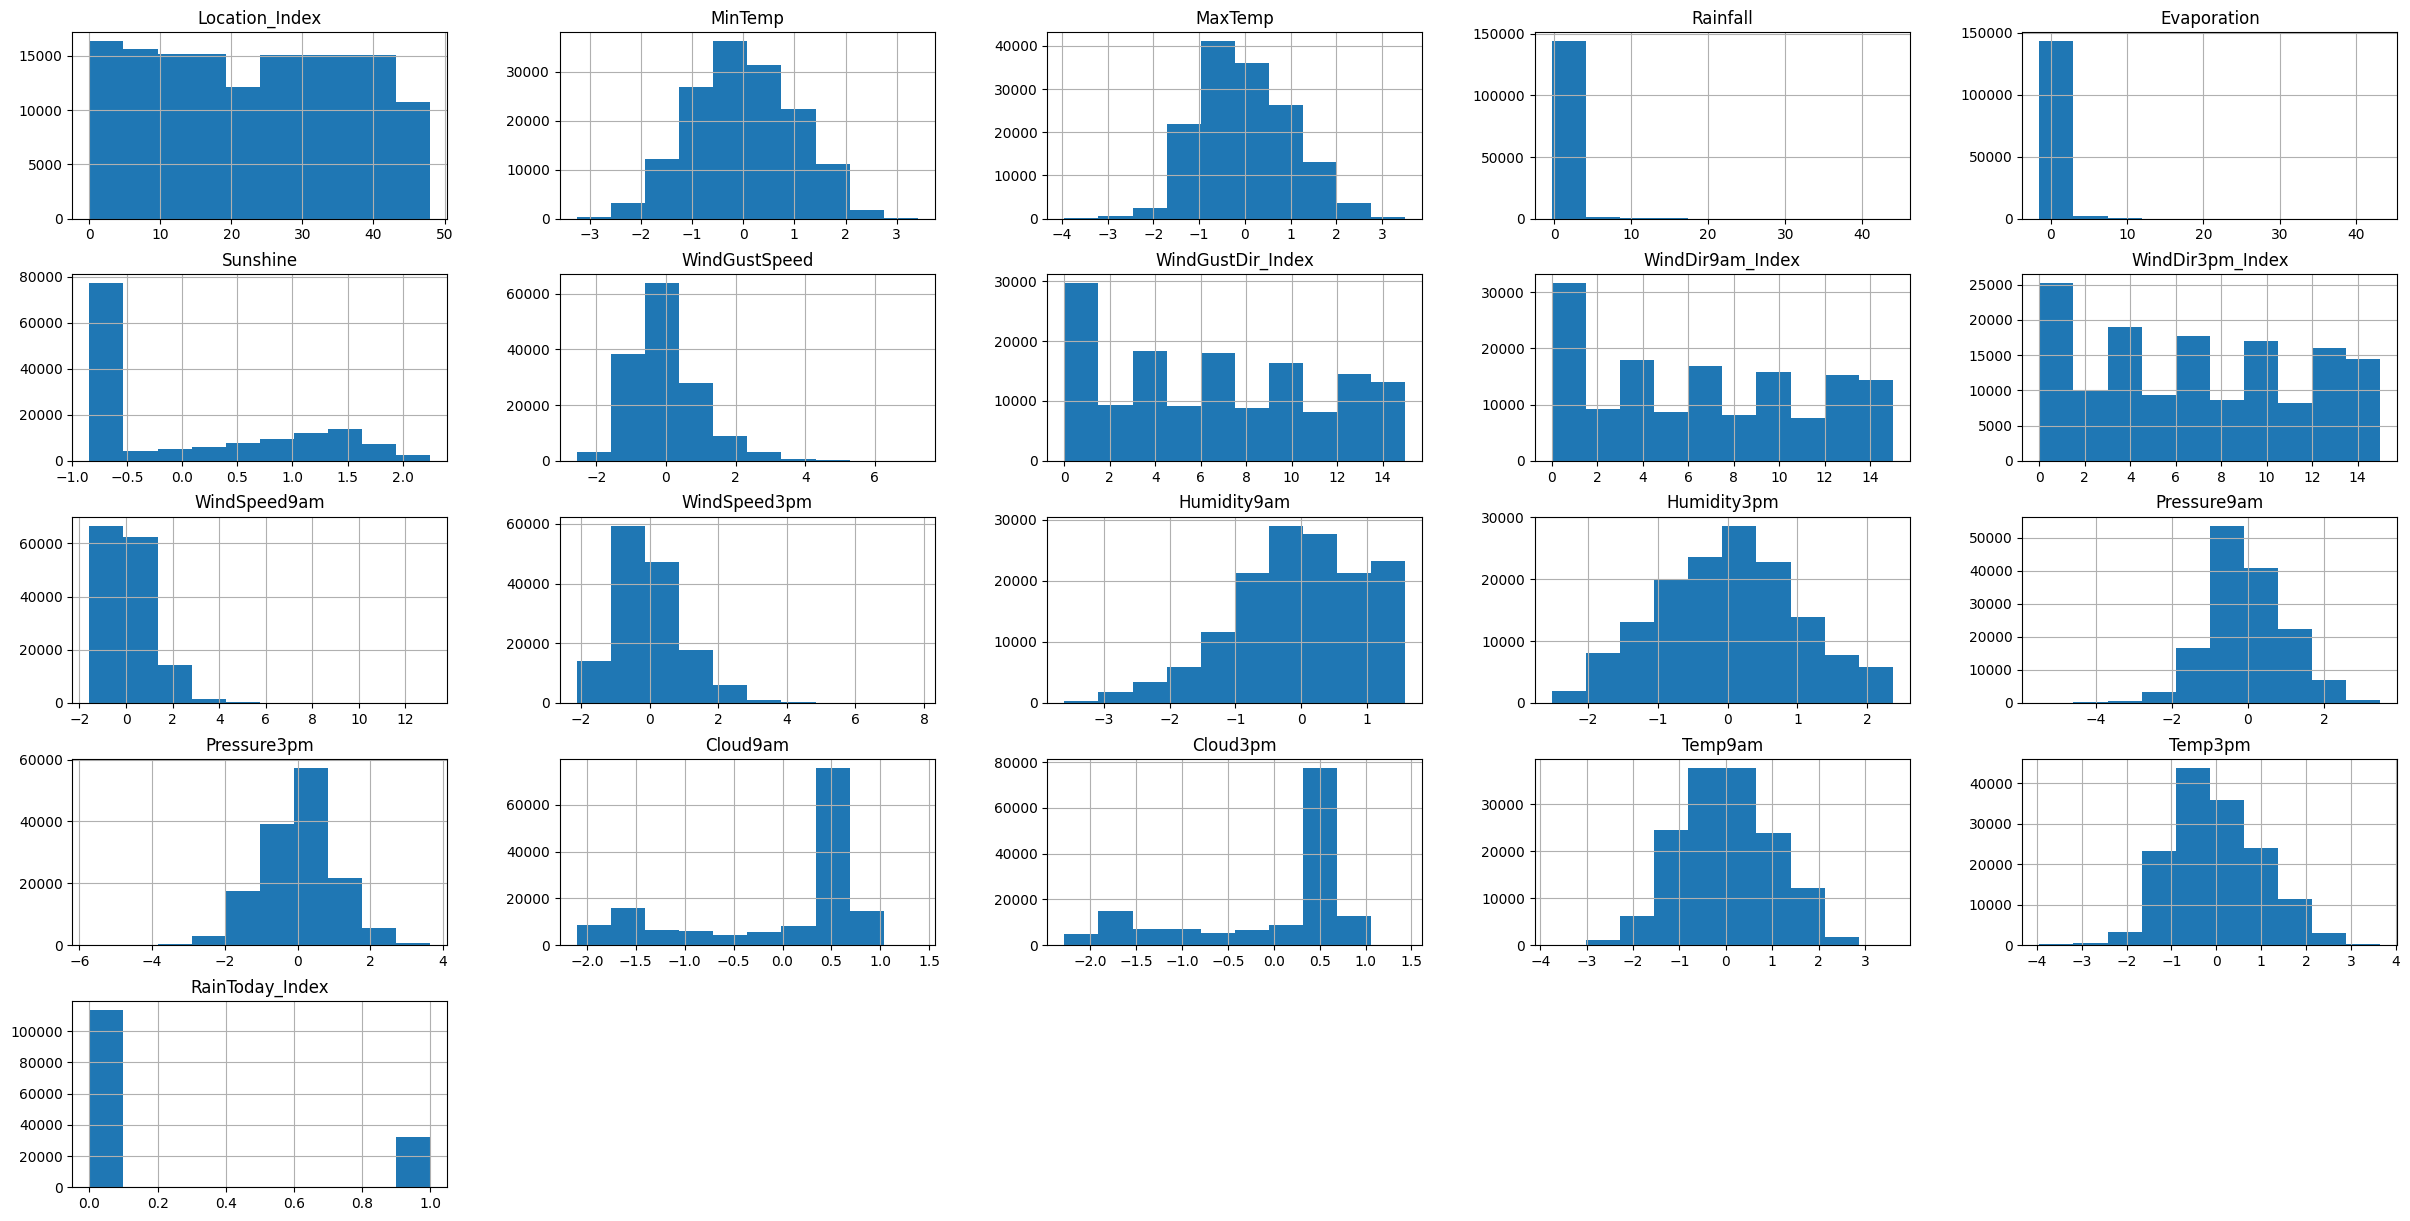

In [18]:
show_features.toPandas().hist(figsize=(30, 15))

### Correlation matrix

In [19]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=show_features.columns, outputCol=vector_col)
df_vector = assembler.transform(show_features).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

<AxesSubplot:>

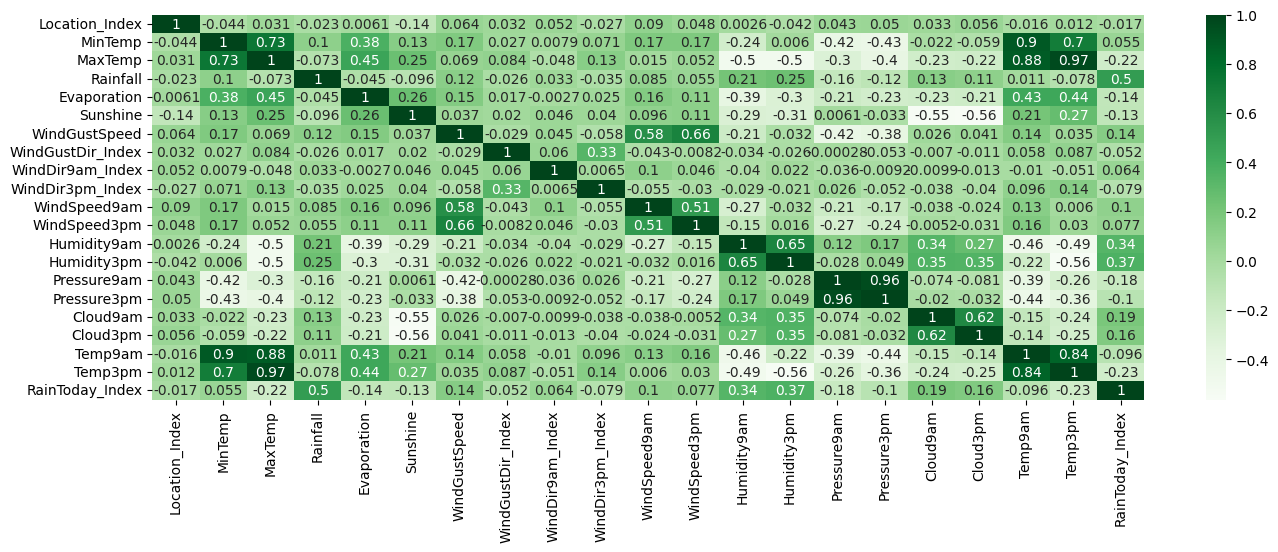

In [20]:
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix)


plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix_df,
            xticklabels=show_features.columns,
            yticklabels=show_features.columns,  cmap="Greens", annot=True)

## Data Training and predictions

## Logistic regression

In [21]:
#Create a logistic regression model object
from pyspark.ml.classification import LogisticRegression
log_reg=LogisticRegression().fit(training_df)

In [22]:
lr_summary=log_reg.summary
lr_summary.accuracy

0.8477397798742138

In [23]:
#Area under ROC
lr_summary.areaUnderROC

0.8652810872953876

In [24]:
#Precision of both classes
print(lr_summary.precisionByLabel)

[0.8689875682476654, 0.7260527533549282]


In [25]:
#Recall of both classes
print(lr_summary.recallByLabel)

[0.9478263059161243, 0.4917834594546187]


In [26]:
#Get Preditions
predictions_lr = log_reg.transform(test_df)

In [27]:
print(dir(lr_summary))

['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_call_java', '_create_from_java_class', '_java_obj', '_new_java_array', '_new_java_obj', 'accuracy', 'areaUnderROC', 'fMeasureByLabel', 'fMeasureByThreshold', 'falsePositiveRateByLabel', 'featuresCol', 'labelCol', 'labels', 'objectiveHistory', 'pr', 'precisionByLabel', 'precisionByThreshold', 'predictionCol', 'predictions', 'probabilityCol', 'recallByLabel', 'recallByThreshold', 'roc', 'scoreCol', 'totalIterations', 'truePositiveRateByLabel', 'weightCol', 'weightedFMeasure', 'weightedFalsePositiveRate', 'weightedPrecision', 'weightedRecall', 'weightedTruePositiveRate']


### Confusion matrix

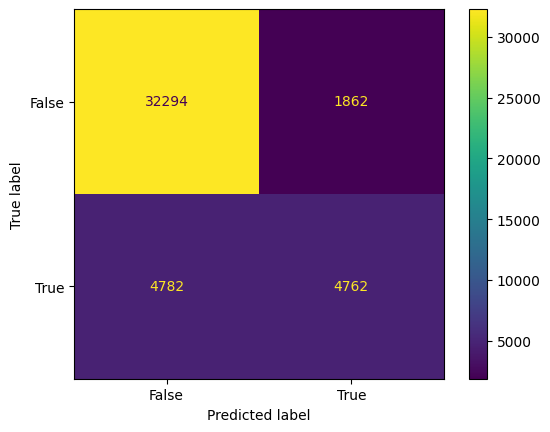

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

predictions_np = predictions_lr.select("prediction", "label").toPandas().to_numpy()
confusion_matrix = confusion_matrix(predictions_np[:, 1], predictions_np[:, 0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## Decision Tree


In [29]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt_classifier = DecisionTreeClassifier(labelCol="label").fit(training_df)

In [30]:
dt_predictions = dt_classifier.transform(test_df)
dt_predictions.show()

+--------------------+-----+----------------+--------------------+----------+
|            features|label|   rawPrediction|         probability|prediction|
+--------------------+-----+----------------+--------------------+----------+
|(110,[1,48,49,50,...|  1.0|[25432.0,5943.0]|[0.81058167330677...|       0.0|
|(110,[1,48,49,50,...|  0.0|[44461.0,3836.0]|[0.92057477690125...|       0.0|
|(110,[1,48,49,50,...|  0.0|[25432.0,5943.0]|[0.81058167330677...|       0.0|
|(110,[1,48,49,50,...|  0.0|[25432.0,5943.0]|[0.81058167330677...|       0.0|
|(110,[1,48,49,50,...|  0.0|[25432.0,5943.0]|[0.81058167330677...|       0.0|
|(110,[1,48,49,50,...|  0.0|[25432.0,5943.0]|[0.81058167330677...|       0.0|
|(110,[1,48,49,50,...|  1.0| [2412.0,1216.0]|[0.66482910694597...|       0.0|
|(110,[1,48,49,50,...|  0.0|[44461.0,3836.0]|[0.92057477690125...|       0.0|
|(110,[1,48,49,50,...|  0.0|[44461.0,3836.0]|[0.92057477690125...|       0.0|
|(110,[1,48,49,50,...|  0.0|[25432.0,5943.0]|[0.81058167330677..

In [31]:
dt_accuracy = MulticlassClassificationEvaluator(labelCol='label',metricName='accuracy').evaluate(dt_predictions)
dt_weightedPrecision = MulticlassClassificationEvaluator(labelCol='label',metricName='weightedPrecision').evaluate(dt_predictions)
dt_auc = MulticlassClassificationEvaluator(labelCol='label').evaluate(dt_predictions)
dt_f1score = MulticlassClassificationEvaluator(labelCol='label',metricName='f1').evaluate(dt_predictions)

In [32]:
print(dt_accuracy)
print(dt_weightedPrecision)
print(dt_auc)
print(dt_f1score)

0.8354233409610984
0.825820443726674
0.8116100543709108
0.8116100543709108


### Confusion matrix

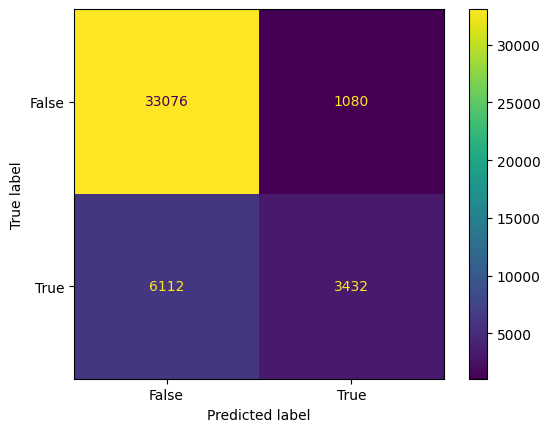

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

predictions_np = dt_predictions.select("prediction", "label").toPandas().to_numpy()
confusion_matrix = confusion_matrix(predictions_np[:, 1], predictions_np[:, 0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# Regression

In [34]:
df_regression = spark.read.option("header",True).option("sep",";").csv("household_power_consumption.txt").drop('Date','Time')
psdf_regression = ps.DataFrame(df_regression)


### Strings to floats

In [35]:
for col in psdf_regression:
    psdf_regression[col] = psdf_regression[col].astype(float)

### Filling missing data with mode (most common value)

In [36]:
psdf_nulls_regression = psdf_regression.replace('NA', None)
print(psdf_nulls_regression.isnull().sum())

C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
C:\spark-3.3.1-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [37]:
data_mode_regression = psdf_nulls_regression.copy()
for i in range(len(psdf_nulls_regression.columns)):
    data_mode_regression.iloc[:, i].fillna(psdf_nulls_regression.iloc[:, i].mode()[0], inplace=True)

print(data_mode_regression.isnull().sum())

C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
C:\spark-3.3.1-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


### Standarization

In [38]:
data_mode_std_regression = data_mode_regression.copy()
for col in data_mode_regression:
    data_mode_std_regression[col] = (data_mode_std_regression[col] - data_mode_std_regression[col].mean()) / data_mode_std_regression[col].std()

In [39]:
print(data_mode_std_regression.isnull().sum())

C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
C:\spark-3.3.1-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [40]:
data_mode_std_regression.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,9.470186e-14,3.637744e-14,1.424895e-12,3.442589e-14,1.567230e-13,-1.158538e-13,5.112519e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.521796e-01,-1.082496e+00,-5.479769e+00,-9.881564e-01,-1.811541e-01,-2.215663e-01,-7.578960e-01
25%,-7.360937e-01,-6.748959e-01,-5.665194e-01,-7.175735e-01,-1.811541e-01,-2.215663e-01,-7.578960e-01
50%,-4.764114e-01,-1.964082e-01,6.394180e-02,-4.469906e-01,-1.811541e-01,-2.215663e-01,-6.390588e-01
75%,4.163647e-01,6.187929e-01,6.260772e-01,4.098552e-01,-1.811541e-01,-4.877333e-02,1.262337e+00
max,9.516616e+00,1.123413e+01,4.132435e+00,9.880256e+00,1.420811e+01,1.360187e+01,2.926058e+00


### Indexing strings and creating vectors

In [41]:
data_sprak_regression = data_mode_std_regression.to_spark()


C:\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [42]:
data_sprak_regression.show()

+-------------------+---------------------+-------------------+------------------+-------------------+--------------------+------------------+
|Global_active_power|Global_reactive_power|            Voltage|  Global_intensity|     Sub_metering_1|      Sub_metering_2|    Sub_metering_3|
+-------------------+---------------------+-------------------+------------------+-------------------+--------------------+------------------+
|  2.971486139197089|    2.621352312751228|-1.8647104169762743| 3.115684086815259|-0.1811541150295248|-0.04877333452036018|1.2623368581990453|
|  4.055706817959462|   2.7808481923575377|-2.2405025563325727| 4.152918498008956|-0.1811541150295248|-0.04877333452036018|1.1434996290018395|
| 4.0689752528394205|   3.3302228887792693| -2.346097041771533| 4.152918498008956|-0.1811541150295248| 0.12401966586782527|1.2623368581990453|
|   4.08224368771938|   3.3656664175806714| -2.206339634572905| 4.152918498008956|-0.1811541150295248|-0.04877333452036018|1.2623368581990453|

In [43]:
from pyspark.ml.feature import VectorAssembler

# specify the input and output columns of the vector assembler
#Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
assembler_regression = VectorAssembler(inputCols=[
                                       'Global_active_power',
                                       'Global_reactive_power',
                                       'Voltage',
                                       'Sub_metering_1',
                                       'Sub_metering_2',
                                       'Sub_metering_3',],
                           outputCol='features')

# transform the data
final_data_regression = assembler_regression.transform(data_sprak_regression)

In [44]:
# view the transformed vector
final_data_regression.select('features','Global_intensity').show()

+--------------------+------------------+
|            features|  Global_intensity|
+--------------------+------------------+
|[2.97148613919708...| 3.115684086815259|
|[4.05570681795946...| 4.152918498008956|
|[4.06897525283942...| 4.152918498008956|
|[4.08224368771938...| 4.152918498008956|
|[2.45022619748441...|2.5294211587492565|
|[2.31185537659340...|2.3490325654981787|
|[2.48434503003287...|2.5294211587492565|
|[2.48244953933573...|2.5294211587492565|
|[2.45212168818154...|2.5294211587492565|
|[2.44643521609013...|2.5294211587492565|
|[3.19136306006498...|3.3862669766918763|
|[4.10498957608502...| 4.198015646321726|
|[3.92681345055414...|4.0176270530706475|
|[3.96851424589115...| 4.062724201383418|
|[2.81795139272899...| 2.935295493564182|
|[2.18296200918809...| 2.168643972247101|
|[2.07491903945128...|2.0784496756215622|
|[2.22655829522224...|2.2137411205598707|
|[2.07112805805700...|2.0784496756215622|
|[2.50898640909565...|2.6647126036875646|
+--------------------+------------

In [45]:
#Model_Dataframe
model_df_regression = final_data_regression.select(['features','Global_intensity'])
model_df_regression = model_df_regression.withColumnRenamed("Global_intensity","label")
model_df_regression.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



### Spliting Datasets

In [46]:
#Split into training & testing Dataframe
training_df_regression,test_df_regression = model_df_regression.randomSplit([0.7,0.3])

In [47]:
import matplotlib.pyplot as plt
show_features_regression = final_data_regression

array([[<AxesSubplot:title={'center':'Global_active_power'}>,
        <AxesSubplot:title={'center':'Global_reactive_power'}>,
        <AxesSubplot:title={'center':'Voltage'}>],
       [<AxesSubplot:title={'center':'Global_intensity'}>,
        <AxesSubplot:title={'center':'Sub_metering_1'}>,
        <AxesSubplot:title={'center':'Sub_metering_2'}>],
       [<AxesSubplot:title={'center':'Sub_metering_3'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

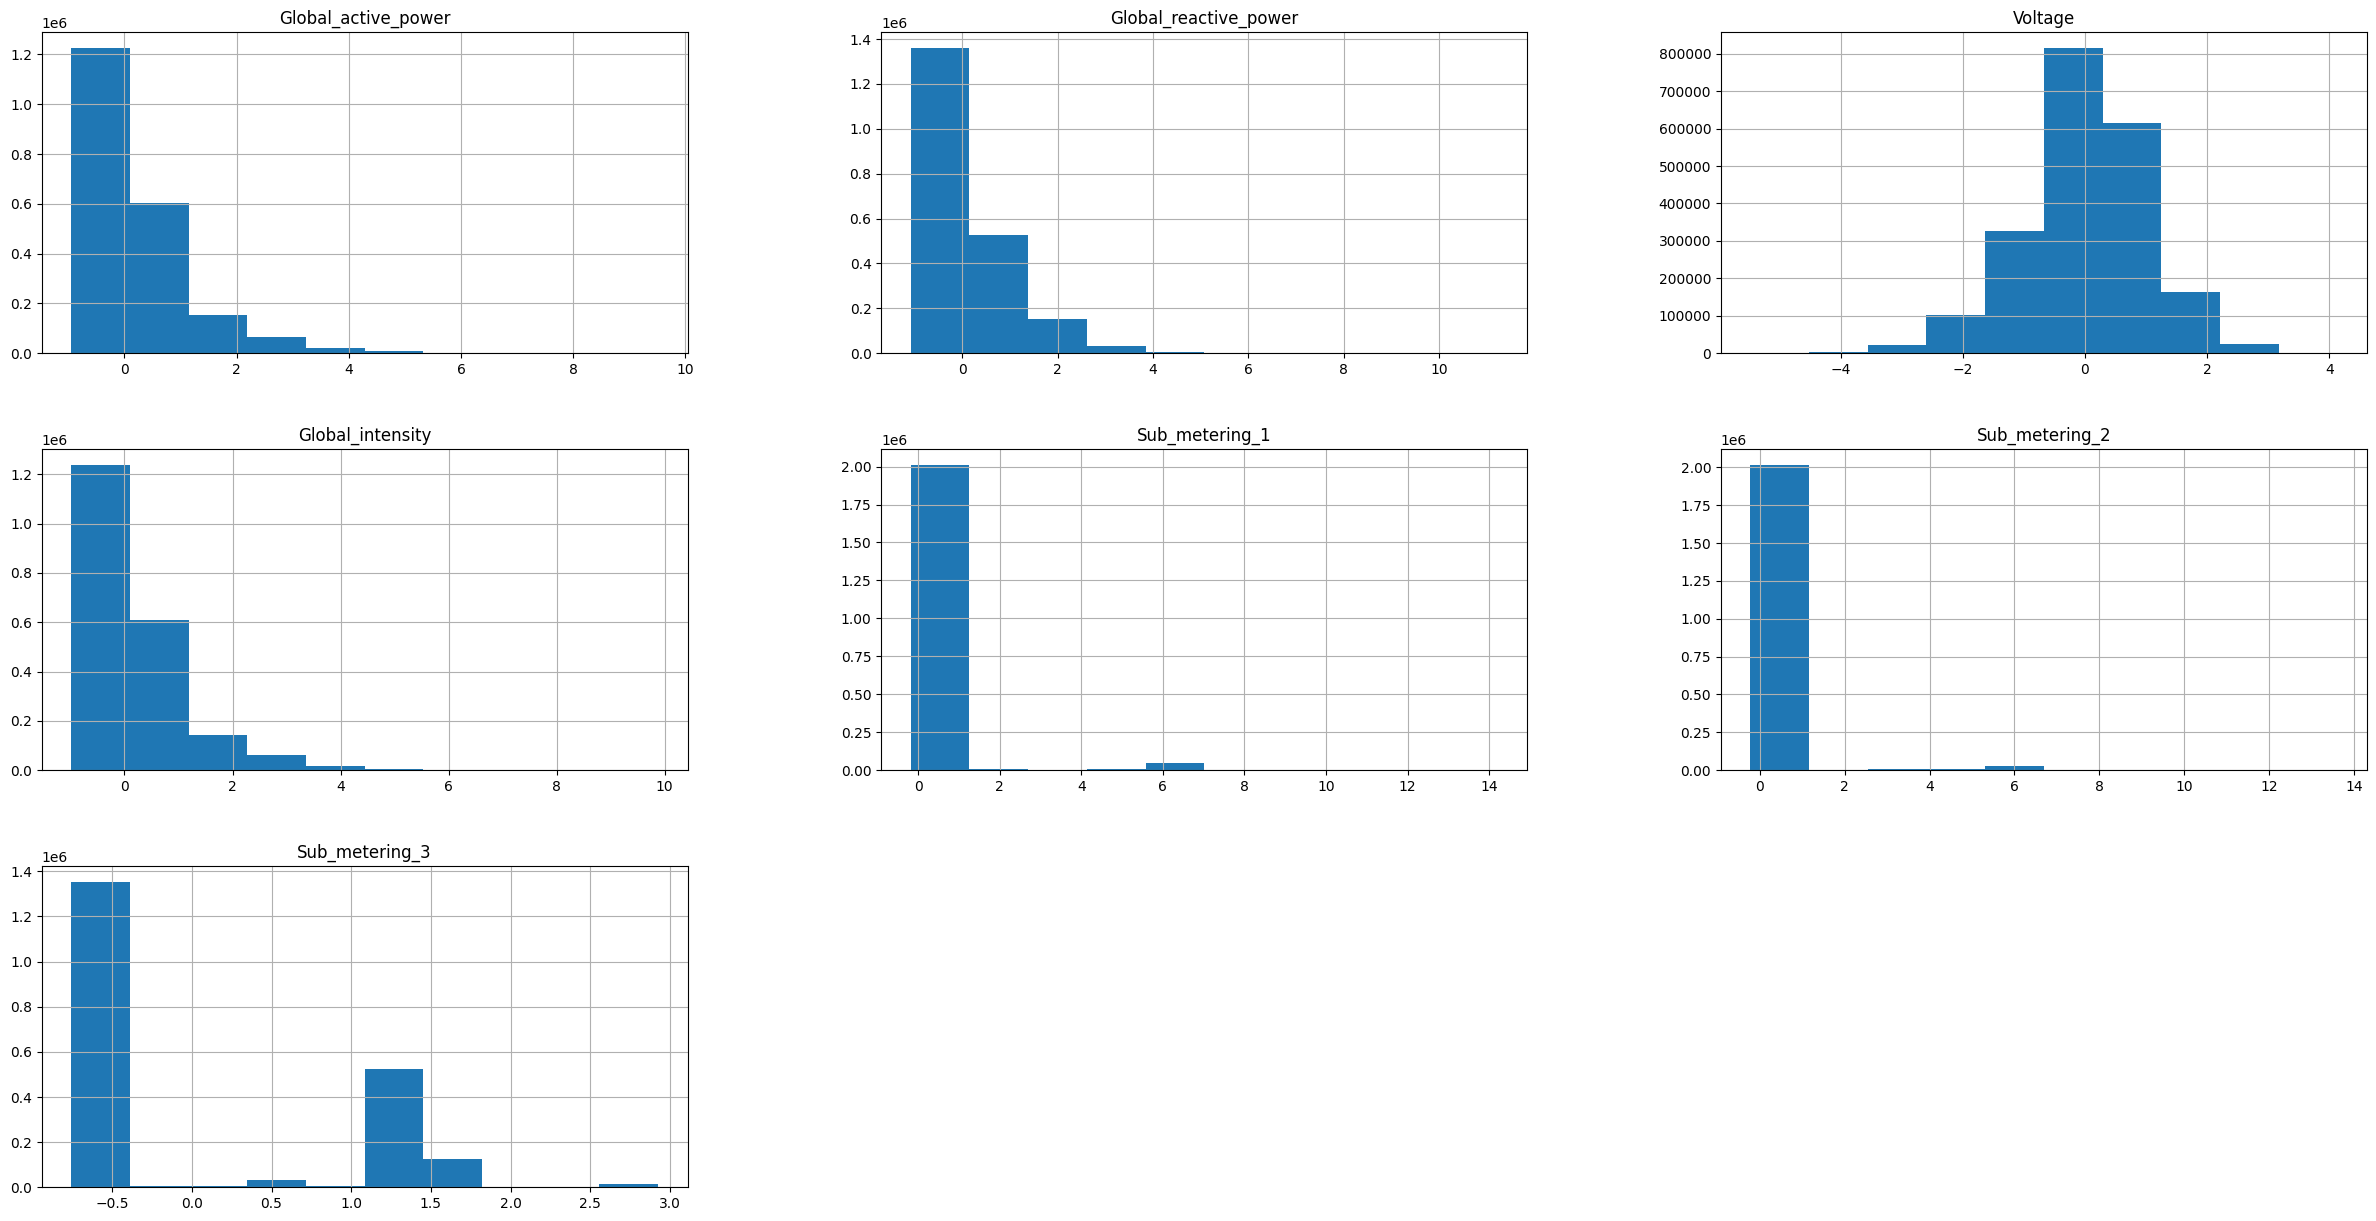

In [48]:
show_features_regression.drop('features').toPandas().hist(figsize=(30, 15))

### Correlation matrix

In [49]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns

show_features_regression_corr = show_features_regression.drop('features')

# convert to vector column first
vector_col_regression = "corr_features_regression"
assembler_regression = VectorAssembler(inputCols=show_features_regression_corr.columns, outputCol=vector_col_regression)
df_vector_regression = assembler_regression.transform(show_features_regression_corr).select(vector_col_regression)

# get correlation matrix
matrix_regression = Correlation.corr(df_vector_regression, vector_col_regression).collect()[0][0]

<AxesSubplot:>

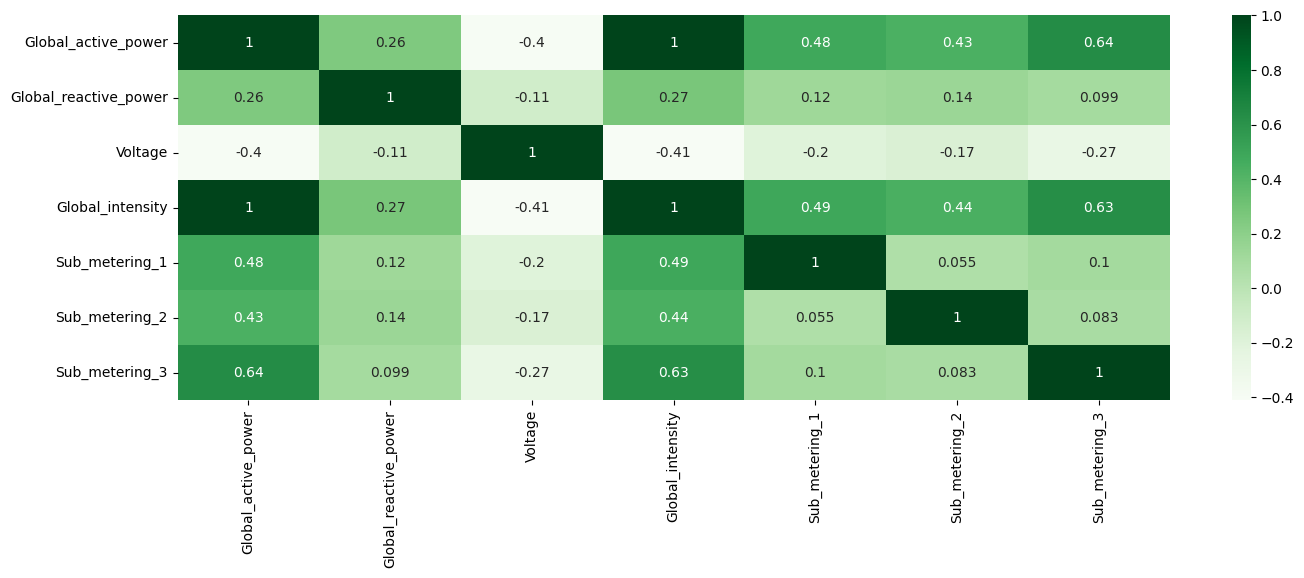

In [50]:
corr_matrix_regression = matrix_regression.toArray().tolist()
corr_matrix_df_regression = pd.DataFrame(data=corr_matrix_regression)


plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix_df_regression,
            xticklabels=data_mode_std_regression.columns,
            yticklabels=data_mode_std_regression.columns,  cmap="Greens", annot=True)


## Linear regression

In [51]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training_df_regression)

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 10
objectiveHistory: [0.5000000000000001, 0.4420488760229014, 0.27272438250229414, 0.25571122598709156, 0.23279227461839352, 0.22823058628784354, 0.22820623415202934, 0.22820069197710496, 0.22819999976827812, 0.22819991331249753, 0.2281999025143081]
+-------------------+
|          residuals|
+-------------------+
|-0.2655402692097628|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
|-0.2668976184071036|
+-------------------+
only showing top 20 rows

RMSE: 0.286898
r2: 0.917811


## Decision Tree regression

In [52]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Train a DecisionTree model.
dt_regression = DecisionTreeRegressor(labelCol="label", featuresCol="features").fit(training_df_regression)

dt_predictions_regression = dt_regression.transform(test_df_regression)

In [53]:
training_df_regression.show()

+--------------------+-------------------+
|            features|              label|
+--------------------+-------------------+
|[-0.9464931317851...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
|[-0.9445976410879...|-0.9430592613339903|
+----------

In [54]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select example rows to display.
dt_predictions_regression.select("prediction", "label", "features").show(5)

+-------------------+-------------------+--------------------+
|         prediction|              label|            features|
+-------------------+-------------------+--------------------+
|-0.9161203311170761|-0.9430592613339903|[-0.9445976410879...|
|-0.9161203311170761|-0.9430592613339903|[-0.9445976410879...|
|-0.9161203311170761|-0.9430592613339903|[-0.9445976410879...|
|-0.9161203311170761|-0.9430592613339903|[-0.9445976410879...|
|-0.9161203311170761|-0.9430592613339903|[-0.9445976410879...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [55]:
dt_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction",metricName='rmse').evaluate(dt_predictions_regression)
dt_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction",metricName='r2').evaluate(dt_predictions_regression)

In [56]:
print(dt_rmse)
print(dt_r2)

0.1537739071535707
0.9762719160679921
